In [56]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [17]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [18]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [19]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

In [20]:
drop_columns = ['Unnamed: 0','trans_date_trans_time','first','last','street','city','state','zip','dob','job','trans_num']
df = df.drop(columns=drop_columns)

In [21]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1


In [22]:
#handling categorical columns

cat_col = ['merchant','category','gender']
encoders = {}
for col in cat_col:
    encoders[col]=LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])

In [23]:
#function to define distance between transaction location and merchant location

def haversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a, b, c, d in zip(lat1,lon1,lat2,lon2)])

df['distance'] = haversine(df['lat'],df['long'],df['merch_lat'],df['merch_long'])


In [24]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [25]:
#features

features = ['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x=df[features]
y=df['is_fraud']

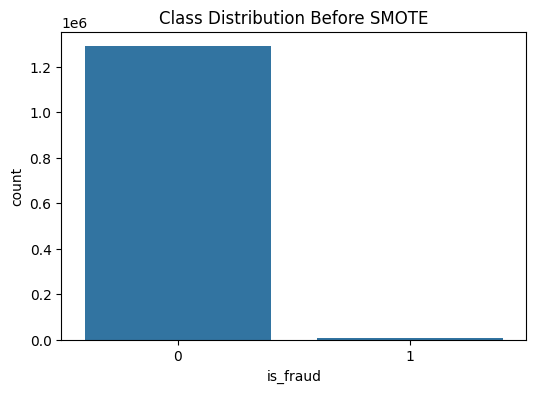

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title("Class Distribution Before SMOTE")
plt.show()

As you can see No. of fraudulent transactions are less compared to ligitimate transactions

In [28]:
#balancing using smote

smote = SMOTE(random_state=42)
x_resample,y_resample = smote.fit_resample(x,y)

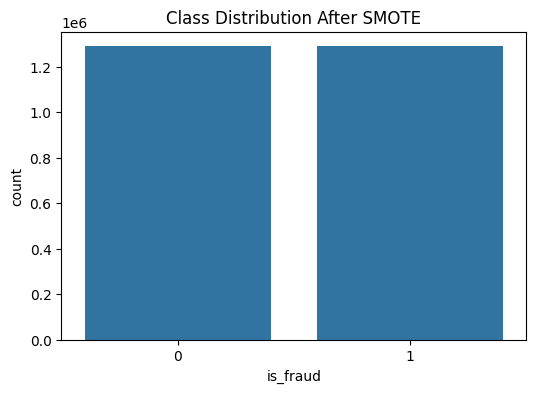

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [30]:
x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,test_size=0.2,random_state=42)

In [42]:
#lgb classifier

lgb_model = lgb.LGBMClassifier(
    boosting_type = 'gbdt',
    objective = 'binary',
    metrics = 'auc',
    is_unbalance = True,
    learning_rate = 0.5,
    num_leaves = 31,
    max_depth = 1,
    n_estimators = 200
)
lgb_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(is_unbalance=True, learning_rate=0.5, max_depth=1, metrics='auc',
               n_estimators=200, objective='binary')

In [43]:
y_pred = lgb_model.predict(x_test)

In [45]:
print("Classification_Report:\n", classification_report(y_test,y_pred))
print("Roc AUC Score: ",roc_auc_score(y_test,y_pred))

Classification_Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91    257186
           1       0.94      0.87      0.90    258482

    accuracy                           0.91    515668
   macro avg       0.91      0.91      0.91    515668
weighted avg       0.91      0.91      0.91    515668

Roc AUC Score:  0.9055656257301193


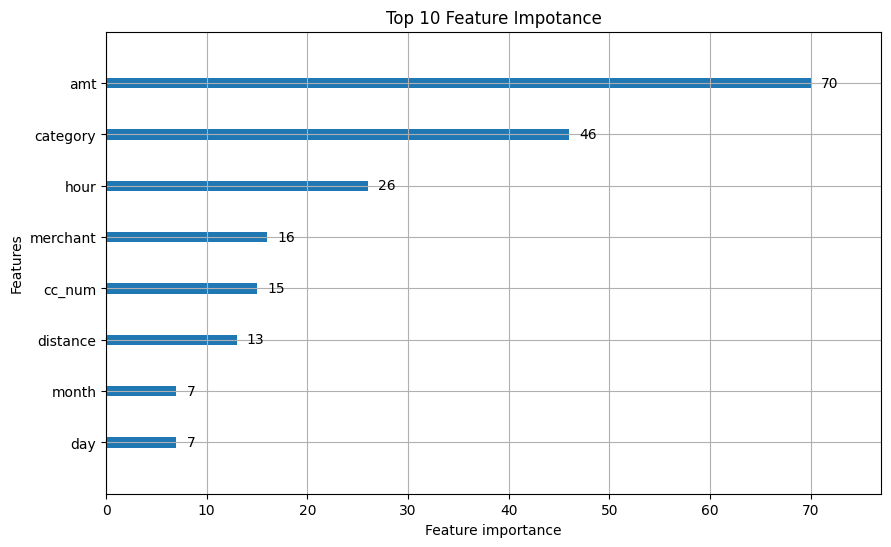

In [46]:
lgb.plot_importance(lgb_model,max_num_features=10,importance_type='split',figsize=(10,6))
plt.title("Top 10 Feature Impotance")
plt.show()

In [47]:
fpr,tpr,thresholds = roc_curve(y_test,lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr,tpr)

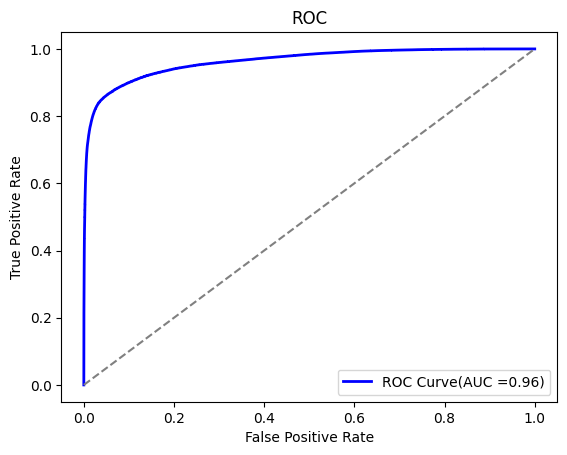

In [48]:
plt.Figure(figsize=(6,6))
plt.plot(fpr,tpr,color='blue',lw=2,label=f'ROC Curve(AUC ={roc_auc:.2f})')
plt.plot([0,1],[0,1],color='gray',linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "lower right")
plt.show()

In [50]:
joblib.dump(lgb_model,"fraud_detection_model.jb")
joblib.dump(encoders,"label_encoder.jb")

['label_encoder.jb']

In [51]:
#for checking fraudulent transaction 
df[df['is_fraud']==1].head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
2449,4613314721966,543,4,281.06,1,35.9946,-81.7266,885,1325466397,36.430124,-81.179483,1,1,2,1,68.962726
2472,340187018810220,285,2,11.52,0,29.4400,-98.4590,1595797,1325468849,29.819364,-99.142791,1,1,2,1,78.443229
2523,340187018810220,196,4,276.31,0,29.4400,-98.4590,1595797,1325473523,29.273085,-98.836360,1,3,2,1,41.048425
2546,4613314721966,162,2,7.03,1,35.9946,-81.7266,885,1325475483,35.909292,-82.091010,1,3,2,1,34.211963
2553,340187018810220,328,4,275.73,0,29.4400,-98.4590,1595797,1325476547,29.786426,-98.683410,1,3,2,1,44.124854


In [61]:
# Copy row
row = df.loc[2449].copy()

# Decode label-encoded columns
row['gender'] = encoders['gender'].inverse_transform([int(row['gender'])])[0]
row['category'] = encoders['category'].inverse_transform([int(row['category'])])[0]
row['merchant'] = encoders['merchant'].inverse_transform([int(row['merchant'])])[0]

# Display full row
print(row)

cc_num               4613314721966.0
merchant      fraud_Rutherford-Mertz
category                 grocery_pos
amt                           281.06
gender                             M
lat                          35.9946
long                        -81.7266
city_pop                       885.0
unix_time               1325466397.0
merch_lat                  36.430124
merch_long                -81.179483
is_fraud                         1.0
hour                             1.0
day                              2.0
month                            1.0
distance                   68.962726
Name: 2449, dtype: object


C:\Users\Vyshnav\AppData\Local\Temp\ipykernel_34516\1238815393.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'M' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  row['gender'] = encoders['gender'].inverse_transform([int(row['gender'])])[0]
